In [65]:
from commonfunctions import *
from skimage.filters import threshold_otsu, sobel
from skimage.morphology import closing, erosion, dilation, remove_small_objects, disk
from skimage.feature import canny, corner_peaks, corner_harris
from skimage.measure import find_contours
from scipy.ndimage import binary_fill_holes

In [54]:
def get_gray(img):
    gray = rgb2gray(np.copy(img))
    return gray

In [55]:
def get_thresholded(img, thresh):
    return 1*(img > thresh)

In [56]:
def preprocess(img):
    gray = get_gray(img)
    edged = sobel(gray)
    thresholded = get_thresholded(edged, threshold_otsu(edged))
    closed = closing(thresholded)
    show_images([img, closed], ['Original', 'After Preprocessing'])
    return closed

In [57]:
def detect_staves(img):
    # # edged = np.copy(img)**2 # Scale down the image pixels values
    # if np.max(img) == 1:
    #     img = img*255
    edged = canny(img, sigma=2)
    dilated = dilation(img)     # Mak it closer to each other
    closed = closing(dilated)   # remove small holes
    filled = binary_fill_holes(closed)
    eroded = erosion(filled, disk(3))
    removed = remove_small_objects(eroded, 7500)
    show_images([dilated, closed], ['Dilated', 'Closed'])
    show_images([filled, eroded, removed], ['Filled', 'Eroded', 'Removed'])
    return removed

In [68]:
def get_box_from_image(img):
    return (0, 0, *img.shape[::-1])

In [79]:
def crop_box(img, bbox):
    minx, miny, maxx, maxy = bbox
    return img[int(miny):int(maxy)+1, int(minx):int(maxx)+1]

In [66]:
def get_boxes(img, staved):
    contours = find_contours(staved, 0.5)
    if len(contours) != 1:
        print('Image Box')
        return get_box_from_image(staved)
    
    staved = sobel(staved)
    coords =corner_peaks(corner_harris(staved),threshold_rel=0,num_peaks=4)
    x = sorted(coords[:, 1])
    y = sorted(coords[:, 0])
    minx, maxx = x[1:3]
    miny, maxy = y[1:3]

    show_images([staved], ['After Sobel'])
    plt.plot(coords[:, 1], coords[:, 0], '+r', markersize=15)
    return (minx, miny, maxx, maxy)

In [72]:
def extract_data(img):
    staved = detect_staves(img)
    box = get_boxes(img, staved)
    cropped = crop_box(staved, box)
    return cropped

In [76]:
def get_staff_boxes(data):
    contours = find_contours(data, 0.5)
    boxes = []
    for contour in contours:
        boxes.append((np.floor(np.min(contour[:, 1])), np.floor(np.min(contour[:, 0])), np.ceil(np.max(contour[:, 1])), np.ceil(np.max(contour[:, 0]))))
    
    return boxes

In [82]:
def get_staves(img, data):
    boxes = get_staff_boxes(data)
    staves = []
    for box in boxes:
        staff = crop_box(img, box)
        if any(dim < 20 for dim in staff.shape):
            continue
        staves.append(staff)
    return staves

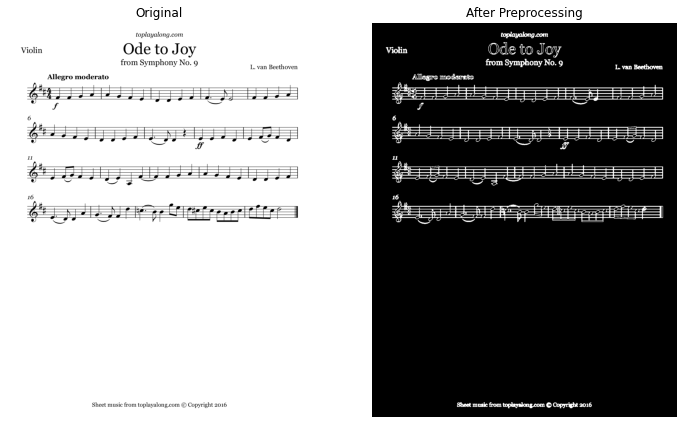

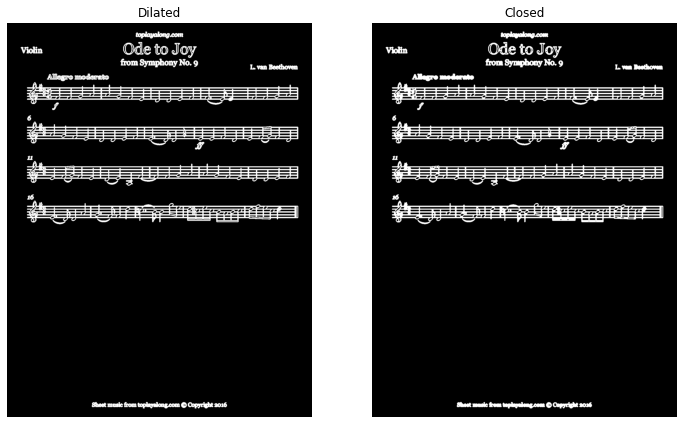

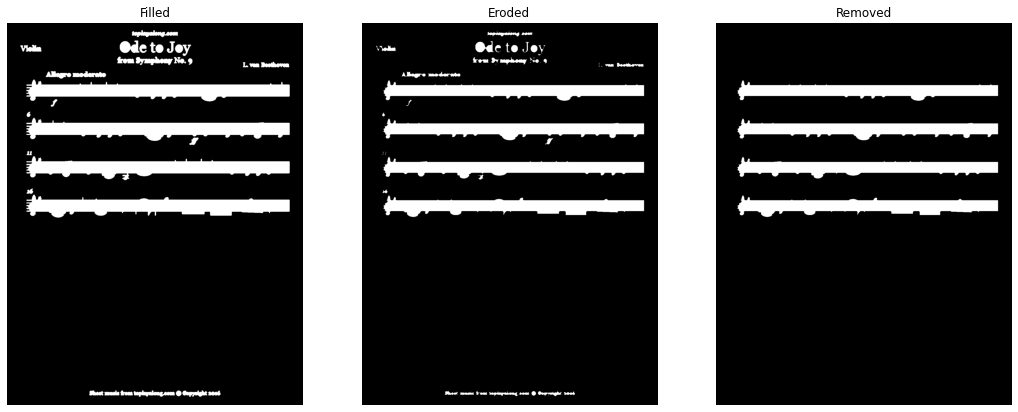

Image Box


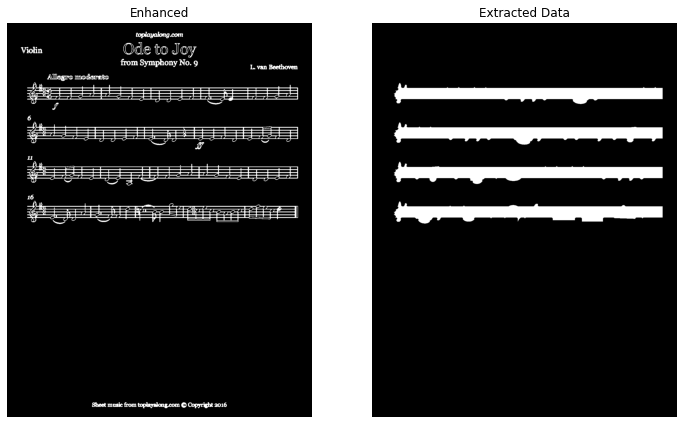

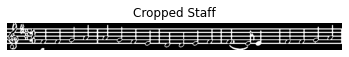

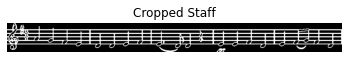

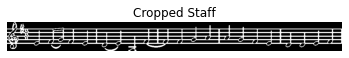

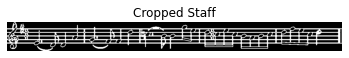

In [83]:
test_img = io.imread('dataset/ode.png')
enhanced = preprocess(test_img)
data = extract_data(enhanced)
staves = get_staves(enhanced, data)

show_images([enhanced, data], ['Enhanced', 'Extracted Data'])
for staff in staves:
    show_images([staff], ['Cropped Staff'])